# Econ 323 Final Project

### Group Members: 
### Nolan Petroff  - Section 004 (Student Number 50933654)
### Shaan Hooey - Section 003 (Student Number ...)

Division of Labour: See Project Proposal

Part 1 - Nolan 
Part 2 - 

## Introduction to Topic and Data

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import os

%matplotlib inline

# Context 
Oil is one of Canada's largest exports both by volume and value. Given a variety of factors including the grade of the oil found in Canada compared to elsewhere, Canadian crude (WCS) is priced at a discount to standard American crude (WTI). In the last few years, industry experts have sounded alarm bells when it comes to the extreme volatility in this price differential and how large it can become. Our goal is to first understand Canada's oil industry and it's economic implications. From here, we want to evaluate if this price differential could change, and if so, quantify some of the impacts. As such, we will proceed as follows:

Part 1: Introduction of the Data Used + Cleaning/Merging

Part 2: Analysis on which economic indicators the differential impacts

Part 3: Discussion on the Price Differential and what "segments" of it can be changed

Part 4: Performance on sensitivity analysis on key variables identified given realistic changes to the price differential

Part 5: If results are significant, a discussion on potential economic policies

### The first part of this project is introducing the data used and getting familiar with the variables we're working with. This section will proceed with discussion of each of the below as follows:

### 1. Oil Prices and the WCS/WTI Differential
### 2. Canadian Oil Production
### 3. Canadian GDP
### 4. Canada - US Exchange Rates
### 5. Creation of a more Useful Combined Dataset

### 1. Oil Prices and the Differential - Data Pulled from Alberta Economic Dashboard
https://economicdashboard.alberta.ca/oilprice



In [39]:
prices = pd.read_csv('Price Data.csv', parse_dates = ["Data"])
prices.head()

,Number,Data,Blend,Unit,Price,Number2,Data2,Blend2,Unit2,Price6,Differential,Unnamed: 11,Unnamed: 12
0,216755,2005-02-01,WCS,$US/bbl,28.44,216573,02-01-2005 12:00:00 AM,WTI,$US/bbl2,48.05,19.61,NaN,NaN
1,216756,2005-03-01,WCS,$US/bbl,36.50,216574,03/01/2005 12:00:00 AM,WTI,$US/bbl,54.63,18.13,NaN,NaN
2,216757,2005-04-01,WCS,$US/bbl,31.02,216575,04/01/2005 12:00:00 AM,WTI,$US/bbl,53.22,22.20,NaN,NaN
3,216758,2005-05-01,WCS,$US/bbl,27.46,216576,05/01/2005 12:00:00 AM,WTI,$US/bbl,49.87,22.41,NaN,NaN
4,216759,2005-06-01,WCS,$US/bbl,38.16,216577,06/01/2005 12:00:00 AM,WTI,$US/bbl,56.42,18.26,NaN,NaN


In [40]:
#Let's clean this data up a bit
prices = prices.drop(['Number','Number2', 'Data2', 'Unit2', 'Unnamed: 11', 'Unnamed: 12'], axis=1)  
names={"Data":"Date",
       "Blend":"Blend",
       "Unit":"Unit",
       "Price":"WCS Price",
       "Blend2":"Blend",
       "Price6":"WTI Price",
       "Differential":"Differential"}

prices.rename(columns=names, inplace=True)

prices["Differential"] = (prices["Differential"]*-1)

prices.tail() #this looks much better now

,Date,Blend,Unit,WCS Price,Blend,WTI Price,Differential
211,2022-09-01,WCS,$US/bbl,64.18,WTI,84.26,-20.08
212,2022-10-01,WCS,$US/bbl,66.38,WTI,87.55,-21.17
213,2022-11-01,WCS,$US/bbl,57.44,WTI,84.37,-26.93
214,2022-12-01,WCS,$US/bbl,47.14,WTI,76.44,-29.30
215,2023-01-01,WCS,$US/bbl,49.94,WTI,78.12,-28.18


We altered the differential to a negative value since it's main interpretation is the "discount" Canadian crude receives relative to WTI. This is more intuitive as a lower value is worse (from our Canadian view) and a higher value is better. 

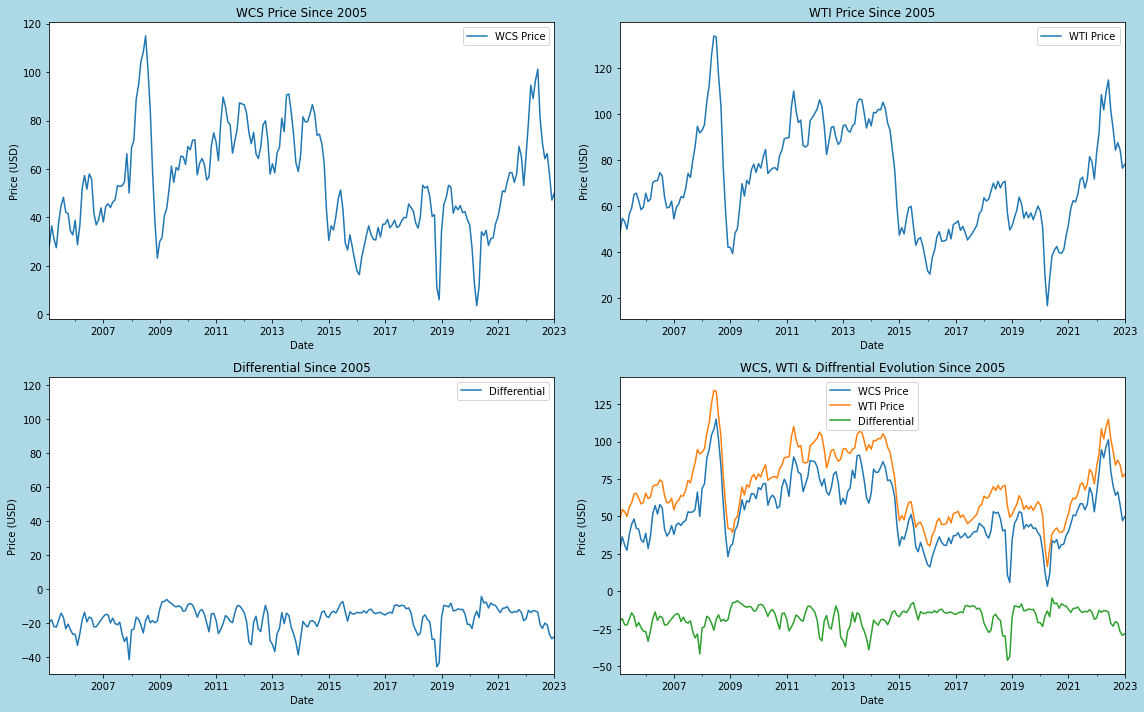

In [41]:
fig, axes = plt.subplots(2,2, figsize = (16,10))
fig.set_facecolor('lightblue')


prices.plot("Date", "WCS Price", 
            title="WCS Price Since 2005", 
            ylabel='Price (USD)', 
            ax = axes[0, 0])

prices.plot("Date", "WTI Price", 
            title="WTI Price Since 2005",
            ylabel='Price (USD)', 
            ax = axes[0, 1])

prices.plot("Date", "Differential", 
            title="Differential Since 2005",
            ylim = (-50, 125),
            ylabel='Price (USD)', 
            ax = axes[1, 0])

prices.plot("Date", ["WCS Price", "WTI Price", "Differential"],
            title='WCS, WTI & Diffrential Evolution Since 2005',
            ylabel='Price (USD)',
            ax = axes[1, 1])

fig.tight_layout()

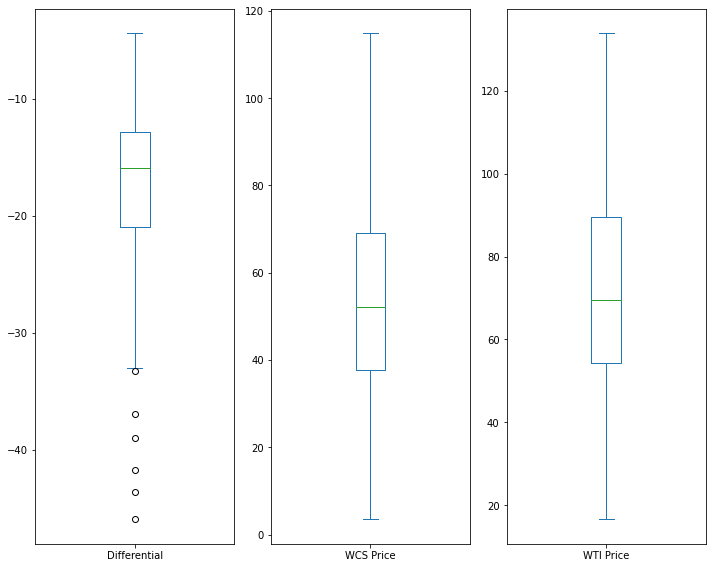

In [42]:
fig, axes = plt.subplots(1,3, figsize= (10, 8))

prices.plot("Date", "Differential", kind="box", ax = axes[0])
prices.plot("Date", "WCS Price", kind="box", ax = axes[1])
prices.plot("Date", "WTI Price", kind="box", ax = axes[2])

fig.tight_layout()

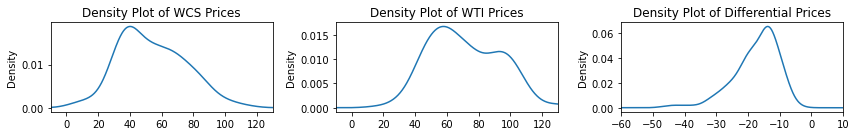

In [51]:
fig, axes = plt.subplots(1,3, figsize = (12, 2))

prices['WCS Price'].plot.density(xlim=(-10, 130), ax=axes[0], title='Density Plot of WCS Prices')
prices['WTI Price'].plot.density(xlim=(-10, 130), ax=axes[1], title='Density Plot of WTI Prices')
prices['Differential'].plot.density(xlim=(-60, 10), ax=axes[2], title='Density Plot of Differential Prices')

fig.tight_layout()

Seen above, the differential is typically in the range of 10-20 USD but frequently spikes to 30 or 40. Many of these instances are due to acute capacity constraints or market dynamics (such as refinery closures). The difference in grade and transport costs have remained relatively constant over this period. As such, events related to supply constraints and/or market changes are to blame for these intense spikes. As will be shown below, the coefficient of variation (measuring relative variance) is higher for the differential than oil prices.

<AxesSubplot:title={'center':'Count of Months 2005-Present Categorized by Differential Size'}, ylabel='Count'>

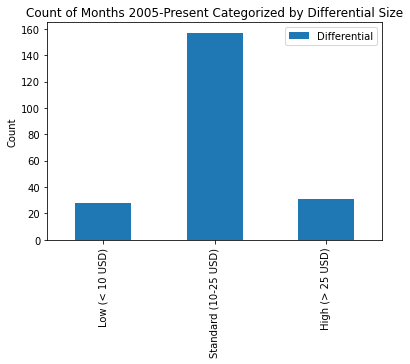

In [53]:
def diffclass(x):
    if abs(x) > 25:
        out = "High (> 25 USD)"
    elif abs(x) > 10:
        out = "Standard (10-25 USD)"
    else:
        out = "Low (< 10 USD)"
    return out

x = (prices['Differential'].apply(diffclass))
x = pd.DataFrame(x)
x = x.apply(pd.value_counts)
x = x.reindex(['Low (< 10 USD)', 'Standard (10-25 USD)', 'High (> 25 USD)'])
x.plot.bar(title='Count of Months 2005-Present Categorized by Differential Size', ylabel='Count')

### Some VERY Elementary Analysis

In [54]:
prices1 = (prices
           .reset_index()
           .pivot_table(index="Date")
           .drop("index", axis=1))

print(prices1.mean())

print(prices1.std() / prices.mean())

Differential   -17.455880
WCS Price       53.962037
WTI Price       71.417917
dtype: float64
Differential   -0.404859
WCS Price       0.388328
WTI Price       0.312554
dtype: float64


/tmp/ipykernel_116/782554030.py:8: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(prices1.std() / prices.mean())
/tmp/ipykernel_116/782554030.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(prices1.std() / prices.mean())


In [98]:
print(np.abs(prices1['2008-01-01':'2012-12-01']['Differential'].std() / prices1['2008-01-01':'2012-12-01']['Differential'].mean()))
print(np.abs(prices1['2013-01-01':'2017-12-01']['Differential'].std() / prices1['2013-01-01':'2017-12-01']['Differential'].mean()))
print(np.abs(prices1['2018-01-01':'2022-12-01']['Differential'].std() / prices1['2018-01-01':'2022-12-01']['Differential'].mean()))

0.38652073709029333
0.4002003585442732
0.4764791723130897


As one can see oil prices, and in particular the differential, is extremely variable and this variability has been growing over time. 

### Canadian Oil Production - Retrieved from the US Energy Information Agency
https://www.eia.gov/international/data/world/petroleum-and-other-liquids/annual-petroleum-and-other-liquids-production (note this ends in 2021)

For 2022 production, here is a source https://www.cer-rec.gc.ca/en/data-analysis/energy-commodities/crude-oil-petroleum-products/statistics/estimated-production-canadian-crude-oil-equivalent.html. We took the average amount for our 2022 production measure which was 4,854.594 thousand barrels per day (as the measure from the EIA is also a yearly average).

As stated above, the differential often moves due to capacity constraints. Much of these constraints are due to the significant increase in Canadian oil production over the last few decades, with export capacity not keeping up. Below is some data on production pulled from the International Energy Agency. 

In [60]:
production = pd.read_csv("Production Data.csv")
production.head()

,Year,Country,Canada Total petroleum and other liquids (Mb/d),"Crude oil, NGPL, and other liquids (Mb/d)",Crude oil including lease condensate (Mb/d),NGPL (Mb/d),Other liquids (Mb/d),Refinery processing gain (Mb/d),Unnamed: 8,Country.1,Production,United States Total petroleum and other liquids (Mb/d),"Crude oil, NGPL, and other liquids (Mb/d).1",Crude oil including lease condensate (Mb/d).1,NGPL (Mb/d).1,Other liquids (Mb/d).1,Refinery processing gain (Mb/d).1
0,1973,Canada,1798.109589,1798.109589,1798.109589,NaN,NaN,NaN,NaN,United States,NaN,9207.953296,9207.953296,9207.953296,NaN,NaN,NaN
1,1974,Canada,1550.953425,1550.953425,1550.953425,NaN,NaN,NaN,NaN,United States,NaN,8774.205438,8774.205438,8774.205438,NaN,NaN,NaN
2,1975,Canada,1430.230137,1430.230137,1430.230137,NaN,NaN,NaN,NaN,United States,NaN,8374.736962,8374.736962,8374.736962,NaN,NaN,NaN
3,1976,Canada,1313.983607,1313.983607,1313.983607,NaN,NaN,NaN,NaN,United States,NaN,8131.639273,8131.639273,8131.639273,NaN,NaN,NaN
4,1977,Canada,1321.134247,1321.134247,1321.134247,NaN,NaN,NaN,NaN,United States,NaN,8244.561600,8244.561600,8244.561600,NaN,NaN,NaN


This doesn't look very accessible - let's clean things up again and also add our 2022 production data. 

Index(['Year', 'Country',
       '        Canada Total petroleum and other liquids (Mb/d)',
       '            Crude oil, NGPL, and other liquids (Mb/d)',
       '                Crude oil including lease condensate (Mb/d)',
       '                NGPL (Mb/d)', '                Other liquids (Mb/d)',
       '            Refinery processing gain (Mb/d)', 'Unnamed: 8',
       'Country.1', '    Production',
       '       United States Total petroleum and other liquids (Mb/d)',
       '            Crude oil, NGPL, and other liquids (Mb/d).1',
       '                Crude oil including lease condensate (Mb/d).1',
       '                NGPL (Mb/d).1',
       '                Other liquids (Mb/d).1',
       '            Refinery processing gain (Mb/d).1'],
      dtype='object')


/tmp/ipykernel_116/900499345.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  production = production.append(s, ignore_index=True)


<AxesSubplot:title={'center':'Canada Production (1973-2021)'}, xlabel='Year', ylabel='Production (000s of BPD)'>

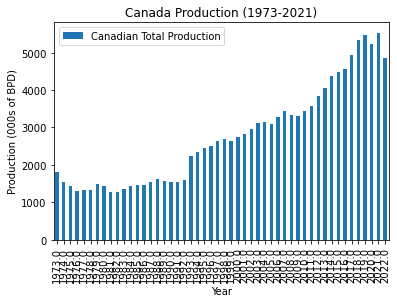

In [61]:
print(production.columns) #get a look at how these column names are stored (quite strangely)

production=production.drop(['Unnamed: 8', '    Production'], axis=1)

colnames = {'        Canada Total petroleum and other liquids (Mb/d)':'Canadian Total Production',
           '            Crude oil, NGPL, and other liquids (Mb/d)':'Canada Crude Production',
           '                Crude oil including lease condensate (Mb/d)':'Canada Crude + Consdensate Production',
           '                NGPL (Mb/d)':'Canada NPGL',
           '                Other liquids (Mb/d)':'Canada Other Liquids',
           '            Refinery processing gain (Mb/d)':'Canada Refinery Processing Gain', 
           '       United States Total petroleum and other liquids (Mb/d)':'USA Total Production',
           '            Crude oil, NGPL, and other liquids (Mb/d).1':'USA Crude Production',
           '                Crude oil including lease condensate (Mb/d).1':'USA Crude + Consdensate Production',
           '                NGPL (Mb/d).1':'USA NPGL',
           '                Other liquids (Mb/d).1':'USA Other Liquids',
           '            Refinery processing gain (Mb/d).1':'USA Refinery Processing Gain',}

production.rename(columns=colnames, inplace=True)

s = [2022]

production = production.append(s, ignore_index=True)

production.loc[49, 'Year'] = 2022
production.loc[49, 'Country'] = 'Canada'
production.loc[49, 'Canadian Total Production'] = 4854.594

production.plot.bar('Year', 'Canadian Total Production', 
                    title='Canada Production (1973-2021)',
                    ylabel='Production (000s of BPD)')

#change label to five year intervals #

Note that our data is from 1973 - 2922. This is great that is shows the longer run change in production, but unfortunately all our other data is from 2005-present and on a monthly basis (this was the only free data available). Below we will alter the production data so that it can be used with our other datasets. While this is less than ideal, growth in Canadian oil production is fairly steady especially when compared to the volatility of our other variables. As seen on the left graph, over time (including our 2005-2021 time span of interest), the growth in production is fairly consistent so it shouldn't impact our results too significantly.

In [62]:
production1 = production.drop(index=range(0,32))

# when we get 2022 data, add it here so that we can multiply it by 12 to get 12 months

production1 = production1.loc[production1.index.repeat(12)] #couldn't get monthly data, so repeating yearly data 12 times (best esimate)

production1 = production1.reset_index()

production1

,index,Year,Country,Canadian Total Production,Canada Crude Production,Canada Crude + Consdensate Production,Canada NPGL,Canada Other Liquids,Canada Refinery Processing Gain,Country.1,USA Total Production,USA Crude Production,USA Crude + Consdensate Production,USA NPGL,USA Other Liquids,USA Refinery Processing Gain,0
0,32,2005.0,Canada,3096.284614,3018.907614,2368.877597,645.430016,4.6,77.377,United States,8327.137027,7337.737008,5183.712329,1716.994559,437.030121,989.400019,NaN
1,32,2005.0,Canada,3096.284614,3018.907614,2368.877597,645.430016,4.6,77.377,United States,8327.137027,7337.737008,5183.712329,1716.994559,437.030121,989.400019,NaN
2,32,2005.0,Canada,3096.284614,3018.907614,2368.877597,645.430016,4.6,77.377,United States,8327.137027,7337.737008,5183.712329,1716.994559,437.030121,989.400019,NaN
3,32,2005.0,Canada,3096.284614,3018.907614,2368.877597,645.430016,4.6,77.377,United States,8327.137027,7337.737008,5183.712329,1716.994559,437.030121,989.400019,NaN
4,32,2005.0,Canada,3096.284614,3018.907614,2368.877597,645.430016,4.6,77.377,United States,8327.137027,7337.737008,5183.712329,1716.994559,437.030121,989.400019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,49,2022.0,Canada,4854.594000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0
212,49,2022.0,Canada,4854.594000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0
213,49,2022.0,Canada,4854.594000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0
214,49,2022.0,Canada,4854.594000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.0


### A Look at Canadian GDP - Pulled from Statistics Canada
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3610043402

In [63]:
cadgdp = pd.read_csv("GDP Data.csv", parse_dates = ["REF_DATE"])

print(cadgdp.index)

#initial amount of 7000 rows doesn't make sense; we only need the rows that count total GDP (not only certain industries)

RangeIndex(start=0, stop=7740, step=1)


In [64]:
cadgdp1 = cadgdp.loc[cadgdp['North American Industry Classification System (NAICS)'] == 'All industries [T001]']

cadgdp1.tail()

,REF_DATE,GEO,DGUID,Seasonal adjustment,Prices,North American Industry Classification System (NAICS),UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
210,2022-08-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2064938.0,NaN,NaN,NaN,0
211,2022-09-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2068200.0,NaN,NaN,NaN,0
212,2022-10-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2069351.0,NaN,NaN,NaN,0
213,2022-11-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2071062.0,NaN,NaN,NaN,0
214,2022-12-01,Canada,2016A000011124,Seasonally adjusted at annual rates,Chained (2012) dollars,All industries [T001],Dollars,81,millions,6,v65201210,1.1.1.1,2068605.0,NaN,NaN,NaN,0


In [65]:
#Just some data cleaning to get what we want from this set
cadgdp1 = cadgdp1[['REF_DATE', 'GEO', 'Prices', 'SCALAR_FACTOR', 'VALUE']]

colnames = {'REF_DATE':'Date',
            'GEO':'Country',
            'SCALAR_FACTOR':'Scale',
            'VALUE':'GDP'}

cadgdp1.rename(columns=colnames, inplace=True)

cadgdp1.head()

,Date,Country,Prices,Scale,GDP
0,2005-02-01,Canada,Chained (2012) dollars,millions,1516009.0
1,2005-03-01,Canada,Chained (2012) dollars,millions,1510876.0
2,2005-04-01,Canada,Chained (2012) dollars,millions,1522079.0
3,2005-05-01,Canada,Chained (2012) dollars,millions,1528603.0
4,2005-06-01,Canada,Chained (2012) dollars,millions,1533199.0


<AxesSubplot:title={'center':'Canadian GDP Since 2005'}, xlabel='Date', ylabel='Trillions of Dollars (CAD)'>

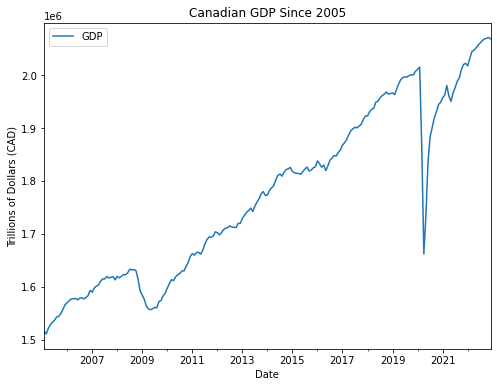

In [67]:
cadgdp1.plot("Date", 
             "GDP", 
             title="Canadian GDP Since 2005",
             ylabel='Trillions of Dollars (CAD)',
             figsize=(8,6))

### Canada-US Exchange Rates - Data from the Federal Reserve Bank of St. Louis
https://fred.stlouisfed.org/series/DEXCAUS

In [68]:
xrates = pd.read_csv("Exchange rate data.csv", parse_dates=["DATE"])

xrates.head()

,DATE,DEXCAUS
0,2005-02-01,1.240053
1,2005-03-01,1.216026
2,2005-04-01,1.235900
3,2005-05-01,1.255529
4,2005-06-01,1.240168


<AxesSubplot:title={'center':'CAD/USD Exchange Rate Over Time'}, xlabel='DATE'>

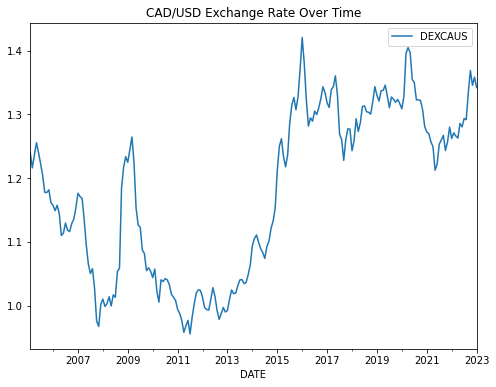

In [69]:
xrates.plot("DATE", "DEXCAUS", title="CAD/USD Exchange Rate Over Time", figsize = (8,6))

### We've Now Went Through all the Raw Data - Let's Make Our Own Dataset!

In [74]:
df = pd.DataFrame(xrates['DEXCAUS'])

df['Date'] = pd.DataFrame(prices['Date'])

df['WCS Prices'] = pd.DataFrame(prices['WCS Price'])

df['WTI Prices'] = pd.DataFrame(prices['WTI Price'])

df['Differential'] = pd.DataFrame(prices['Differential'])

df['GDP'] = pd.DataFrame(cadgdp1['GDP'])

df['Average Production Per Day (Millions of BPD)'] = pd.DataFrame(production1['Canadian Total Production'] / 1000)

df['Differential (CAD)'] = df['Differential'] * df['DEXCAUS']

df.set_index('Date', inplace=True)

df.index = df.index.to_period('M') #changing the index to month (removed the -01 from each)

df['Monthly Production Value (Billions of USD)'] = (df['WCS Prices'] * df['Average Production Per Day (Millions of BPD)'] / 
                                                    1000) * df.index.daysinmonth
#using df.index.daysinmonth since there are different days in different months (also accounts for leap years)

df['Monthly Production Value (Billions of CAD)'] = (df['WCS Prices'] *df['DEXCAUS'] * 
                                                    df['Average Production Per Day (Millions of BPD)'] / 1000) * df.index.daysinmonth

df['Monthly Differential Impact (Billions of USD)'] = np.abs((df['Average Production Per Day (Millions of BPD)'] * 
                                                              df['Differential'] / 1000) * df.index.daysinmonth)

df['Monthly Differential Impact (Billions of CAD)'] = np.abs((df['Average Production Per Day (Millions of BPD)'] * 
                                                              df['Differential (CAD)'] / 1000) * df.index.daysinmonth)

df.head()

# we finally have a useful dataset with the relevant Canadian information that we want!


,DEXCAUS,WCS Prices,WTI Prices,Differential,GDP,Average Production Per Day (Millions of BPD),Differential (CAD),Monthly Production Value (Billions of USD),Monthly Production Value (Billions of CAD),Monthly Differential Impact (Billions of USD),Monthly Differential Impact (Billions of CAD)
Date,,,,,,,,,,,
2005-02,1.240053,28.44,48.05,-19.61,1516009.0,3.096285,-24.317432,2.465633,3.057515,1.700108,2.108223
2005-03,1.216026,36.50,54.63,-18.13,1510876.0,3.096285,-22.046553,3.503446,4.260282,1.740205,2.116134
2005-04,1.235900,31.02,53.22,-22.20,1522079.0,3.096285,-27.436980,2.881402,3.561125,2.062126,2.548581
2005-05,1.255529,27.46,49.87,-22.41,1528603.0,3.096285,-28.136395,2.635743,3.309251,2.151020,2.700667
2005-06,1.240168,38.16,56.42,-18.26,1533199.0,3.096285,-22.645471,3.544627,4.395933,1.696145,2.103505


## Part 2: Analysis of the Impact the Differential has on Economic Indicators



In [99]:
print(df['Monthly Differential Impact (Billions of CAD)'].mean())

print(df['2008-01':'2012-12']['Monthly Differential Impact (Billions of CAD)'].mean())
print(df['2013-01':'2017-12']['Monthly Differential Impact (Billions of CAD)'].mean())
print(df['2018-01':'2022-12']['Monthly Differential Impact (Billions of CAD)'].mean())

2.625164672018455
1.8178529662548564
2.6348475750874405
3.496274833163102


In [100]:
df.describe()

,DEXCAUS,WCS Prices,WTI Prices,Differential,GDP,Average Production Per Day (Millions of BPD),Differential (CAD),Monthly Production Value (Billions of USD),Monthly Production Value (Billions of CAD),Monthly Differential Impact (Billions of USD),Monthly Differential Impact (Billions of CAD)
count,216.000000,216.000000,216.000000,216.00000,2.150000e+02,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,1.178506,53.962037,71.417917,-17.45588,1.773706e+06,4.236167,-20.321295,6.809621,7.911716,2.220291,2.625165
std,0.130929,20.954957,22.321942,7.06717,1.614657e+05,0.828101,8.049072,2.636333,3.051890,0.971087,1.245767
min,0.955315,3.500000,16.550000,-45.93000,1.510876e+06,3.096285,-60.649646,0.549638,0.772129,0.614365,0.752094
25%,1.041851,37.675000,54.252500,-20.90000,1.619354e+06,3.429993,-24.044417,4.956521,5.890167,1.687345,1.924564
50%,1.212335,52.060000,69.585000,-15.87000,1.773250e+06,4.217537,-18.777820,6.553534,7.435418,1.996568,2.449990
75%,1.299947,69.092500,89.620000,-12.83250,1.920772e+06,4.946555,-15.095695,8.745919,9.622204,2.591270,2.868121
max,1.420811,114.950000,134.020000,-4.34000,2.071062e+06,5.537451,-5.881469,14.734178,18.865993,7.369210,9.730894


In [101]:
df.corr()

#keep certain columns; namely DEXCAUS - Production 

,DEXCAUS,WCS Prices,WTI Prices,Differential,GDP,Average Production Per Day (Millions of BPD),Differential (CAD),Monthly Production Value (Billions of USD),Monthly Production Value (Billions of CAD),Monthly Differential Impact (Billions of USD),Monthly Differential Impact (Billions of CAD)
DEXCAUS,1.000000,-0.685942,-0.730068,0.272055,0.643763,0.711433,-0.015622,-0.330246,-0.036030,0.067466,0.308132
WCS Prices,-0.685942,1.000000,0.948610,-0.031109,-0.116919,-0.285446,0.164424,0.873688,0.701872,-0.096082,-0.251111
WTI Prices,-0.730068,0.948610,1.000000,-0.345806,-0.145129,-0.320957,-0.146716,0.803067,0.615066,0.187840,0.002737
Differential,0.272055,-0.031109,-0.345806,1.000000,0.112258,0.167374,0.950944,0.054064,0.138419,-0.878193,-0.753215
GDP,0.643763,-0.116919,-0.145129,0.112258,1.000000,0.945365,-0.071468,0.344952,0.562019,0.320764,0.461456
Average Production Per Day (Millions of BPD),0.711433,-0.285446,-0.320957,0.167374,0.945365,1.000000,-0.028214,0.183405,0.404634,0.282779,0.436021
Differential (CAD),-0.015622,0.164424,-0.146716,0.950944,-0.071468,-0.028214,1.000000,0.153679,0.154442,-0.939057,-0.892736
Monthly Production Value (Billions of USD),-0.330246,0.873688,0.803067,0.054064,0.344952,0.183405,0.153679,1.000000,0.950661,0.026941,-0.054782
Monthly Production Value (Billions of CAD),-0.036030,0.701872,0.615066,0.138419,0.562019,0.404634,0.154442,0.950661,1.000000,0.044401,0.032800
Monthly Differential Impact (Billions of USD),0.067466,-0.096082,0.187840,-0.878193,0.320764,0.282779,-0.939057,0.026941,0.044401,1.000000,0.964255


In [102]:
df['Monthly Differential Impact (Billions of CAD)'].sum()

567.0355691559865

That's a lot!! Since from 2005 - 2022, the cumulative impact of the differential is over $567 Billion (CAD). This reveals why this differential is important to look at; even a small change in the differential over time could lead to massive differences in the value of Canadian Oil Production. 

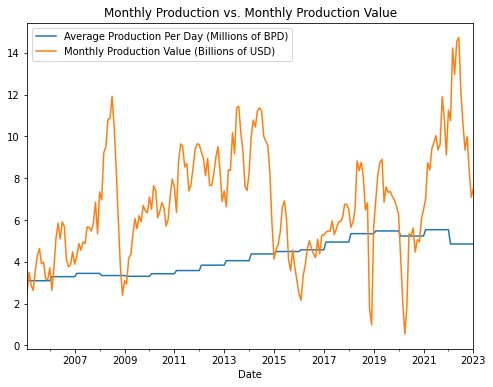

In [104]:
df2 = df.reset_index()

df2.plot('Date', ['Average Production Per Day (Millions of BPD)', 'Monthly Production Value (Billions of USD)'],
        title= 'Monthly Production vs. Monthly Production Value',
        figsize = (8,6))

fig.tight_layout()

# Part 3 - Discussion of the Differential

The WTI (USA Oil) /WCS (CAN Oil) differential is comprised of three factors:
* Endowments (US has higher grade oil than Canada)
* Transport costs (US has less average distance that oil needs to travel from extraction until export than in Canada)
* Export capacity (US has more capacity to move oil than Canada)

Right now, the WTI/WCS differential is about 15 USD. Approximately 5 of these dollars are attributable to differences in endowments, 3-4 dollars to export capacity, and 6-7 to transport costs. As discussed before, note that the differential varies well above and below $15 due to market dynamics. These estimates seem to align with our data. Based on our data, the median is 15.87 USD, and 75% of the time is below 12.83 USD. This 12-13 USD range aligns with the sum of difference in endowments as well as transport costs. As such, we feel that the estimate of 3-4 dollars due to export capacity (on average). While endowments and transport costs cannot be significantly changed, it is worth examining the economic impacts of this 3-4 dollar differential vanishing, since it is possible by public policy. 


In [105]:
prices['Differential'].describe()

count    216.00000
mean     -17.45588
std        7.06717
min      -45.93000
25%      -20.90000
50%      -15.87000
75%      -12.83250
max       -4.34000
Name: Differential, dtype: float64

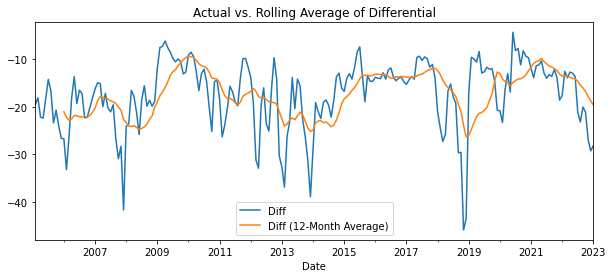

In [106]:
fig, ax = plt.subplots(figsize=(10,4))

df['Differential'].plot(title='Actual vs. Rolling Average of Differential')
df.rolling(12)['Differential'].mean().plot()
ax.legend(['Diff', 'Diff (12-Month Average)'])

# Part 3 - Beginning of Sensitivity Analyses


Plan for this section:

1. State assumption about realistic changes in the differential

Situation 1: Assume a 1 reduction in export capacity constraints
- repeat situation 1 with values up to 3.00 in increments of 0.50
2. Sensitivity Analysis:
- create a probability distribution over which the differential could likely change. This will have a mean of ... with a variance of ...
- from this distribution, calculate the total impact of the differential reduction
- comment on the average likely impact, as well as the tails (ex. according to our assumptions, there is a 10% likelihood that the impact of a differential reduction exceeds ...)

### Discussion on Data Used

- used data for the WCS/WTI differential. Although not all oil/gas from Canada is WCS, a large chunk is and it serves as a reasonable estimate for overall prices. Smaller blends also produced in Canada are light/sweel oil (which fetch higher prices) as well as bitumen (fetching lower prices). As such, WCS is the primary tool used to get an estimate of general prices for Canadian production. Data retrieved from the government of Alberta website's "Economic Dashboard"
https://economicdashboard.alberta.ca/oilprice
- production data was taken from Statista (only website where we didn't need to pay)
- exchange rate data taken from the St. Louis federal reserve database

### Assumptions

- the makeup of Canadian production stayed relatively constant over time
- 